# Disease Course Sequencing with the EBM
## Event-Based Model of disease progression
Author: Neil Oxtoby, UCL

## Objectives:

This notebook walks you through how to fit an event-based model of disease progression using publicly available software and simulated data.

The steps involved:
- Load input data
  - e.g., a CSV table of disease features (biomarkers) in a cohort including patients and healthy controls
- Prepare the input data: select a subset of features; perform some basic statistical checks; etc.
- Fit the model
- Perform cross-validation

We add additional steps as didactic exemplars of good practice in data-driven disease progression modelling. 

## The set-up

This notebook was originally designed to run in a specially prepared conda environment, using the [KDE EBM](https://github.com/ucl-pond/kde_ebm) package (see [installation instructions](https://github.com/ucl-pond/kde_ebm/blob/master/INSTALL.md) on GitHub).

In the future we may support running this in the cloud.

## Install the KDE EBM package

In [1]:
!pip install git+https://github.com/ucl-pond/kde_ebm --use-feature=in-tree-build --force-reinstall

  Cloning https://github.com/ucl-pond/kde_ebm to /private/var/folders/dl/gjzs07_s27v2lff3_khf2mlc0000gn/T/pip-req-build-euwnduad
  Running command git clone -q https://github.com/ucl-pond/kde_ebm /private/var/folders/dl/gjzs07_s27v2lff3_khf2mlc0000gn/T/pip-req-build-euwnduad
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for kde-ebm: filename=kde_ebm-0.0.2-py3-none-any.whl size=77722 sha256=04b0dd2d8ea9e803ea7bdc0cc2db0ed0ea9d7e4b6e7367ae0bf4ade343d2ee88
  Stored in directory: /private/var/folders/dl/gjzs07_s27v2lff3_khf2mlc0000gn/T/pip-ephem-wheel-cache-571s5tea/wheels/62/f9/79/90e0ee5fe59a76a272df769b581bcf4d49e68928b3c4a1bbd3
Successfully built kde-ebm
  Attempting uninstall: kde-ebm
    Found existing installation: kde-ebm 0.0.2
    Uninstalling kde-ebm-0.0.2:
      Successfully uninstalled kde-ebm-0.0.2
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip

In [13]:
# Import some packages
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # default fontsize

## Simulate some data

Text(0, 0.5, 'sigmoid(t)')

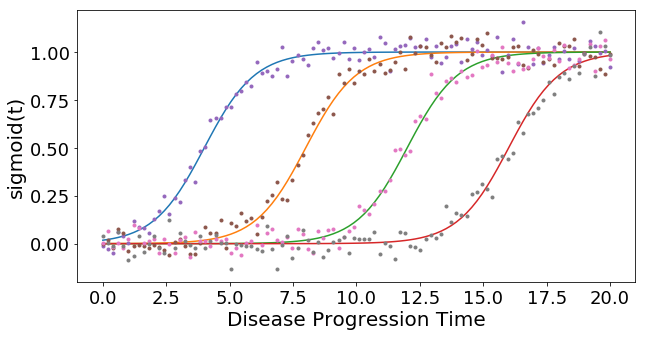

In [14]:
N = 4   # number of events/features
J = 100 # number of patients
N_timepoints_per_individual = 3
noise_scale = 0.05
time_scale = 20

dp = np.linspace(0, time_scale, J)

dp_long = np.reshape(dp,(-1,1))
for kt in range(1,N_timepoints_per_individual):
    next_tp = np.reshape(np.linspace(kt, time_scale+kt, J) + np.random.normal(0, 1/24, dp.size),(-1,1))
    dp_long = np.concatenate(
        (dp_long,next_tp),
        axis=1
    )

def sigmoid(t,a=1,b=-10):
    return 1/(1 + np.exp(-a*(t-b)))

gradients = np.squeeze(np.broadcast_to(1,(1,N)))
onsets    = np.linspace(0,time_scale,N+2)[1:-1]

X = np.empty(shape=(J,N))
X_longitudinal = np.empty(shape=(J,N,N_timepoints_per_individual))
fig,ax = plt.subplots(figsize=(10,5))
for a,b,k in zip(gradients,onsets,range(N)):
    # print('a = %i, b = %i' % (a,b))
    x = sigmoid(t=dp,a=a,b=b)
    #print(x)
    ax.plot(dp, x)
    #y = x + np.random.normal(0, noise_scale, x.size)
    #X[:,k] = y
    #* Longitudinal data
    X_longitudinal[:,k,:] = sigmoid(t=dp_long,a=a,b=b)
    X_longitudinal[:,k,:] += np.random.normal(0, noise_scale, X_longitudinal[:,k,:].shape)
    
    # ax.plot(dp, y,'.')

X = X_longitudinal[:,:,0]
ax.plot(dp, X,'.')

ax.set_xlabel("Disease Progression Time",fontsize=20) 
ax.set_ylabel("sigmoid(t)",fontsize=20)

In [15]:
#* long data format
t_long    = dp_long.ravel().reshape(-1,1)
X_long_id = np.tile(np.arange(1,J+1).reshape((-1,1)),(1,N_timepoints_per_individual)).ravel().reshape((-1,1))
X_long    = np.empty(shape=(J*N_timepoints_per_individual,N))
for kb in range(N):
    X_long[:,kb]    = X_longitudinal[:,kb,:].ravel() #.reshape((-1,1))

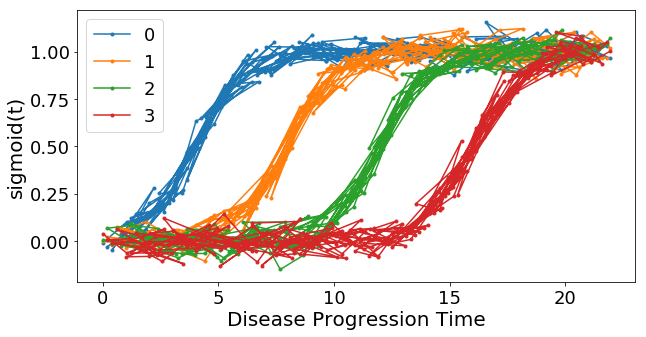

In [16]:
#* Plot long format data to check
fig,ax = plt.subplots(figsize=(10,5))
for kb in range(N):
    ax.plot(t_long, X_long[:,kb],'.-',label=str(kb))
ax.set_xlabel("Disease Progression Time",fontsize=20)
ax.set_ylabel("sigmoid(t)",fontsize=20)
ax.legend()

In [17]:
import pandas as pd
#* Save long format data into dataframe for writing to CSV
df_long = pd.DataFrame(data=X_long)
df_long.columns = ['Biomarker-%i' % (k+1) for k in range(0,N)]
df_long['ID'] = X_long_id
df_long['time'] = t_long
df_long['diagnosis'] = df_long['time'].map(lambda x: 1*(x>onsets[-2]) + 2*( (x>onsets[1]) & (x<onsets[-2]) ))
df_long = df_long[['ID','time','diagnosis']+['Biomarker-%i' % (k+1) for k in range(0,N)]]

df_long.to_csv('simulateddata-raw.csv')

df_long.groupby('diagnosis').describe()

ID                                                         \
           count       mean        std   min    25%   50%    75%    max   
diagnosis                                                                 
0          105.0  18.238095  10.551635   1.0   9.00  18.0  27.00   40.0   
1          135.0  77.814815  13.352391  51.0  67.00  78.0  89.00  100.0   
2           60.0  45.500000   7.124796  31.0  40.75  45.5  50.25   60.0   

            time             ... Biomarker-3           Biomarker-4            \
           count       mean  ...         75%       max       count      mean   
diagnosis                    ...                                               
0          105.0   4.389424  ...    0.036100  0.099146       105.0 -0.007635   
1          135.0  16.595289  ...    1.009644  1.112975       135.0  0.558860   
2           60.0   9.998105  ...    0.267885  0.521299        60.0  0.001762   

                                                                       
                std       min       25%       50%       75%       max  
diagnosis                                                              
0          0.050800 -0.134576 -0.037687 -0.008002  0.021166  0.142313  
1          0.374626 -0.033830  0.181477  0.649796  0.910591  1.102934  
2          0.052980 -0.092875 -0.033635  0.006298  0.034325  0.113576  

[3 rows x 48 columns]

In [18]:
#* Sample some controls
X_controls = np.empty(shape=X.shape)
for k in range(len(gradients)):
    X_controls[:,k] = np.random.normal(0, 0.05, (X_controls.shape[0],))

## Didactic step: Look at the data

1. Visual: look at the histograms of patients and controls
2. Statistical tests: use null hypothesis statistical tests of "differences" to select features
  - Loosely speaking, a significant difference suggests presence of "disease signal" (patient measurements are "different" to controls measurements) in a biomarker

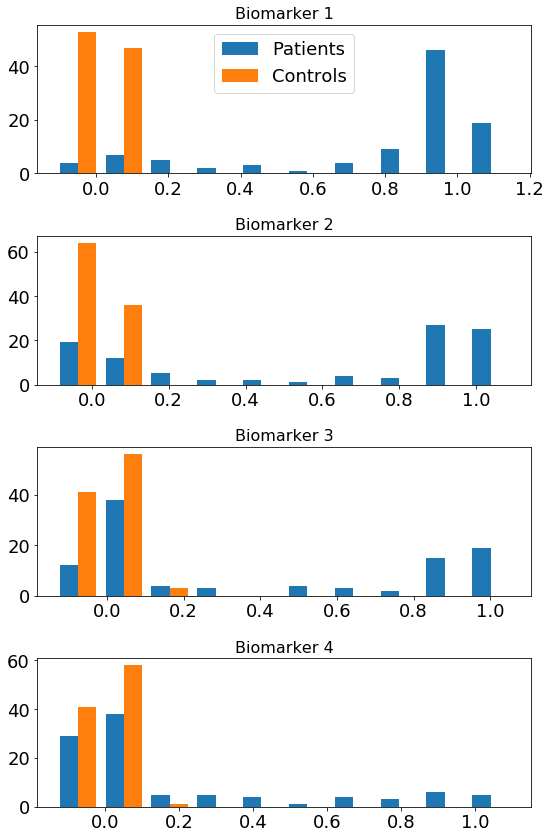

In [19]:
#* 1. Histograms
fig,ax = plt.subplots(N,1,figsize=(8,12))
for k in range(N):
    ax[k].hist([ X[:,k],X_controls[:,k]],label=['Patients','Controls'])
    ax[k].set_title('Biomarker %i' % (k+1),fontsize=16)
ax[0].legend()
fig.tight_layout()

## Basic statistical tests

- Effect size: (difference in medians) / ("width" of controls distribution)

- Mann-Whitney U test (quoting Wikipedia):<br/>
> a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

In [20]:
#* 2. Basic statistics
# I use a nonparametric test because it works regardless of the data distributions 
# (some tests assume some level of Gaussianity)
print('Mann Whitney U test')

for k in range(N):
    x_c = X_controls[:,k]
    x_p = X[:,k]
    effect_size = np.absolute(np.median(x_p)-np.median(x_c))/stats.median_abs_deviation(x_c)
    u,p = stats.mannwhitneyu(x_c,x_p)
    print('Biomarker %i\n - effect size = %.3g\n - u = %i, p = %.2g' % (k+1,effect_size,u,p))

Mann Whitney U test
Biomarker 1
 - effect size = 34.5
 - u = 348, p = 3.1e-30
Biomarker 2
 - effect size = 28.4
 - u = 1290, p = 6.3e-20
Biomarker 3
 - effect size = 3.79
 - u = 1834, p = 5.2e-15
Biomarker 4
 - effect size = 0.876
 - u = 3339, p = 2.5e-05


## Prepare data for fitting

Data matrix `X` has `M` individuals (patients, controls, prodromal/at-risk individuals) and `N` biomarkers/events

In [21]:
#* Setup data for fitting
y          = np.ones(shape=(X.shape[0],1))
y_controls = np.zeros(shape=(X_controls.shape[0],1))

X_patients_controls = np.concatenate((X,X_controls),axis=0)
y_patients_controls = np.concatenate((y,y_controls),axis=0)

X = X_patients_controls
y = y_patients_controls.flatten().astype(int)

## Fit mixture models

This step maps biomarker values `x` (columns of data matrix `X`) to `p(event)`, allowing for patients to be at different stages of cumulative abnormality.

Typical group-level analyses simply compare measurements from patients with controls, e.g., looking for statistical "differences" in the mean values. The mixture model allows for patients to have both abnormal observations that deviate from controls (these are early disease events), and normal observations (these will be later disease events)


In [22]:
from kde_ebm.mixture_model import fit_all_kde_models, fit_all_gmm_models, get_prob_mat

from kde_ebm.plotting import mixture_model_grid, mcmc_uncert_mat, mcmc_trace, stage_histogram

from kde_ebm.mcmc import mcmc, parallel_bootstrap, bootstrap_ebm, bootstrap_ebm_fixedMM, bootstrap_ebm_return_mixtures


In [23]:
#* Label the biomarkers/events
e = ['Early','Early-ish','Late-ish','Late']
e_labels = e
#* Direction of progression (1 = biomarker increases in patients; -1 = biomarker decreases in patients)
#  This is a feature of the KDE EBM software.
e_disease_direction_dict = {'Early':1,'Early-ish':1,'Late-ish':1,'Late':1}
e_disease_direction = [e_disease_direction_dict[f] for f in e]

In [24]:
kde_mixtures = fit_all_kde_models(
    X, y,
    implement_fixed_controls = True,
    patholog_dirn_array      = e_disease_direction
)

(<Figure size 720x720 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f0119a0>,
       dtype=object))

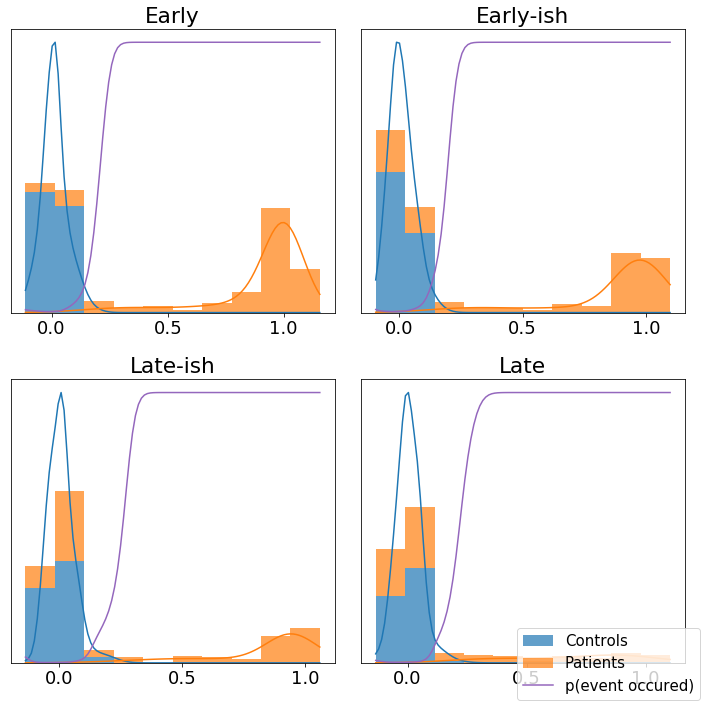

In [25]:
#* View the mixture models
mixture_model_grid(
    X,y,
    kde_mixtures,
    score_names=e,
    class_names=['Controls','Patients']
)

## Sequencing using MCMC: Markov Chain Monte Carlo

This is a standard method for approximating a model posterior when exact inference is intractable.

Here we are performing maximum likelihood inference. The EBM posterior is intractable in general because evaluating the likelihood function requires calculating the likelihood of all `N!` possible sequences for `N` biomarkers.

This quickly explodes for `N > 6`, so we generate _random samples from the posterior_ (the full set of possible sequences) using MCMC, and keep only those sequences that increase the likelihood (ideally towards the maximum).

In general, the posterior won't be a convex function, i.e., one having a single easy-to-find maximum.

In practice, the posterior could consist of multiple maxima at different locations in parameter space. To avoid getting "stuck" in a local maximum, we follow good machine learning practice when searching parameter space to sample from the posterior: multiple random initialisations of the sampling, greedy initialisation, and MCMC sampling.

Details of the bespoke MCMC algorithm used here are in the original EBM paper: [Fonteijn _et al._, NeuroImage (2012)](https://doi.org/10.1016/j.neuroimage.2012.01.062).



/Users/noxtoby/Documents/code/github/kde_ebm/kde_ebm/mcmc/mcmc.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ML order   : Early, Early-ish, Late-ish, Late


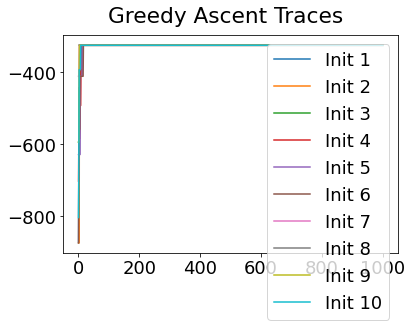

In [11]:
#* MCMC sequencing
mcmc_samples = mcmc(X, kde_mixtures)
#* Maximum Likelihood sequence over all samples
seq_ml = mcmc_samples[0].ordering
# print('ML sequence: {0}'.format(seq_ml))
print('ML order   : %s' % ', '.join([e_labels[k] for k in seq_ml]))
      

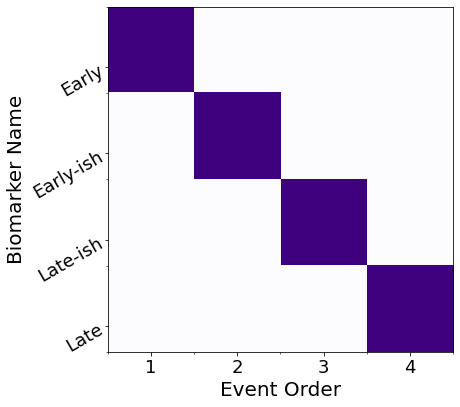

In [12]:
# View the ML posterior
f,a = mcmc_uncert_mat(mcmc_samples, ml_order=None, score_names=e_labels)

### A prettier solution

I define some convenience functions, then use them to plot

In [13]:
import itertools
def extract_pvd(ml_order,samples):
    if type(ml_order) is list:
        #* List of PVDs from cross-validation/bootstrapping
        n_ = len(ml_order[0])
        pvd = np.zeros((n_,n_))
        #all_orders = np.array(ml_order)
        if type(samples[0]) is list:
            #* 10-fold CV returns MCMC samples for each fold separately in a list - concatenate them here
            all_samples = list(itertools.chain.from_iterable(samples))
        else:
            #* Bootstrapping returns MCMC samples pre-concatenated
            all_samples = samples
        all_orders = np.array([x.ordering for x in all_samples])
        for i in range(n_):
            pvd[i, :] = np.sum(all_orders == ml_order[0][i], axis=0)
        #pvd_cv, cv_rank = reorder_PVD_average_ranking(PVD=pvd)
        pvd, rank = reorder_PVD(pvd)
        seq = [ml_order[0][i] for i in rank]
    else:
        #* Single PVD (ML results)
        n_ = len(ml_order)
        pvd = np.zeros((n_,n_))
        samples_ = np.array([x.ordering for x in samples])
        seq = ml_order
        for i in range(n_):
            pvd[i, :] = np.sum(samples_ == seq[i], axis=0)
    return pvd, seq

def reorder_PVD(PVD,mean_bool=False,edf_threshold=0.5):
    """
    Reorders a PVD by scoring the frequencies in each row, then ranking in increasing order.

    Score: integral of complementary empirical distribution (1-EDF) up to a threshold.
    Rationale: the sooner the EDF gets to the threshold, the earlier it should be in the ranking.

    """

    if mean_bool:
        n_ = PVD.shape[0]
        ranking = np.linspace(1,n_,n_) # weights
        weights = PVD
        mean_rank = []
        for i in range(n_):
            mean_rank.append( sum( weights[i,:] * ranking ) / sum(weights[i,:]) )
        new_order = np.argsort(mean_rank)
    else:
        #* Find where the empirical distribution first exceeds the threshold
        edf = np.cumsum(PVD,axis=1)
        edf = edf / np.tile(np.max(edf,axis=1).reshape(-1,1),(1,edf.shape[1]))
        edf_above_threshold = []
        for k in range(edf.shape[0]):
            edf_above_threshold.append(np.where(edf[k,:]>=edf_threshold)[0][0])
        #* Ties implicitly split by original ordering in the PVD (likely the ML ordering)
        edf_rank = np.argsort(edf_above_threshold)
        new_order = edf_rank

    PVD_new = PVD[new_order,:]
    # PVD_new = np.zeros((n_,n_))
    # for i in range(n_):
    #     PVD_new[i, :] = PVD[new_order[i],:]

    return PVD_new, new_order

# Frontiers default is pdf with 300dpi
# And run it all through imagemagick after to convert
def save_plot(fig, fname, fig_format="png", dpi=150, **kwargs):
    fig.savefig(
        f"{fname}.{fig_format}",
        dpi=300,
        bbox_inches="tight",
        **kwargs
    )

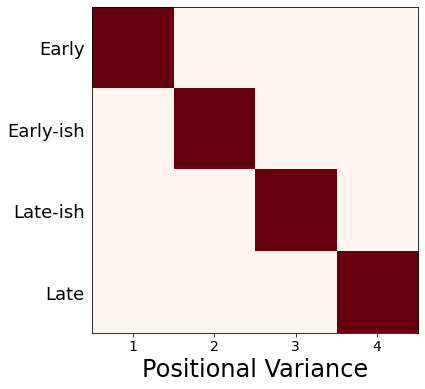

In [14]:
# Get labels
nom = 'tute'
#* Plot EBM (PVD)
pvd_ml, seq_ml = extract_pvd(ml_order=seq_ml,samples=mcmc_samples)
reorder_ml = np.argsort(seq_ml)
pvd_ml_ = pvd_ml[:][reorder_ml]

fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
labels = e_labels
labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_ml]
ax.imshow(pvd_ml_[:][seq_ml], interpolation='nearest', cmap='Reds')

n_biomarkers = pvd_ml.shape[0]
stp = 1
fs = 14
tick_marks_x = np.arange(0,n_biomarkers,stp)
x_labs = range(1, n_biomarkers+1,stp)
ax.set_xticks(tick_marks_x)
ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
tick_marks_y = np.arange(n_biomarkers)
ax.set_yticks(tick_marks_y+0.0)
ax.tick_params(axis='y',color='w')
labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
                   rotation=0, #ha='right',
                   rotation_mode='anchor',
                   fontsize=18)
# ax.set_ylabel('Instrument', fontsize=28)
ax.set_xlabel('Positional Variance', fontsize=24)
ax.grid(False)

save_plot(fig, nom+"-PVD_ML")

## Patient staging utility

Concept: align individuals to the model

Method (see [Young et al, Brain 2014](https://doi.org/10.1093/brain/awu176)): compare data from each individual (patients/controls/at-risk) with the model and calculate a `p(event)` vector, then assign the most likely stage according to the accumulation of disease events

In [15]:
#* Define the EBM staging function
def ebm_staging(x,mixtures,samples):
    """
    Given a trained EBM (mixture_models,mcmc_samples), and correctly-formatted data, stage the data
    NOTE: To use CV-EBMs, you'll need to call this for each fold, then combine.
    Author: Neil P Oxtoby, UCL, September 2018
    """
    if type(mixtures[0]) is list:
        #* List of mixture models from cross-validation / bootstrapping
        n_cv = len(mixtures)
        prob_mat = []
        stages = []
        stage_likelihoods = []
        stages_expected = []
        for k in range(n_cv):
            #* Stage the data
            prob_mat.append(get_prob_mat(x, mixtures[k]))
            stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat[k])
            stages.append(stages_k)
            stage_likelihoods.append(stage_likelihoods_k)
            #* Average (expectation value) stage
            stages_expected_k = np.ndarray(shape=stages_k.shape)
            for kk in range(stages_expected_k.shape[0]):
                stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
            stages_expected.append(stages_expected_k)
    else:
        #* Stage the data
        prob_mat = get_prob_mat(x, mixtures)
        if type(samples[0]) is list:
            n_bs = len(samples)
            stages = []
            stage_likelihoods = []
            stages_expected = []
            for k in range(n_bs):
                #* Stage the data
                stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat)
                stages.append(stages_k)
                stage_likelihoods.append(stage_likelihoods_k)
                #* Average (expectation value) stage
                stages_expected_k = np.ndarray(shape=stages_k.shape)
                for kk in range(stages_expected_k.shape[0]):
                    stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
                stages_expected.append(stages_expected_k)
        else:
            stages, stage_likelihoods = samples[0].stage_data(prob_mat)
            #* Average (expectation value) stage
            stages_expected = np.ndarray(shape=stages.shape)
            for k in range(stages_expected.shape[0]):
                stages_expected[k] = np.sum(stage_likelihoods[k,:]*np.arange(1,stage_likelihoods.shape[1]+1,1))/np.sum(stage_likelihoods[k,:]) - 1
    # #* Average (expectation value) stage
    # stages_expected_n = np.sum(stage_likelihoods,axis=1)
    # stages_expected_ = np.average(stage_likelihoods_long_ml,axis=1,weights=np.arange(1,stage_likelihoods_long_ml.shape[1]+1,1))
    # stages_expected_ = stages_expected_/stages_expected_n
    
    return prob_mat, stages, stage_likelihoods, stages_expected


In [16]:
#* Staging
# df_staging = df_EBM.copy()
# staging_columns = ['RID','VISCODE',dx_column,'Years_bl']+e
# df_staging = df_staging[staging_columns].copy()
# x_long = df_staging[e].values
# df_staging['Fraction missing data'] = np.sum(np.isnan(x_long),axis=1)/x_long.shape[1]
# stage_column = "Model stage"

#* Maximum-likelihood model stage
prob_mat_ml, stages_long_ml, stage_likelihoods_long_ml, stages_long_ml_expected = ebm_staging(
    x=X,
    mixtures=kde_mixtures,
    samples=mcmc_samples
)
stages_long = stages_long_ml

### Plot a staging histogram

Number of individuals in each EBM stage

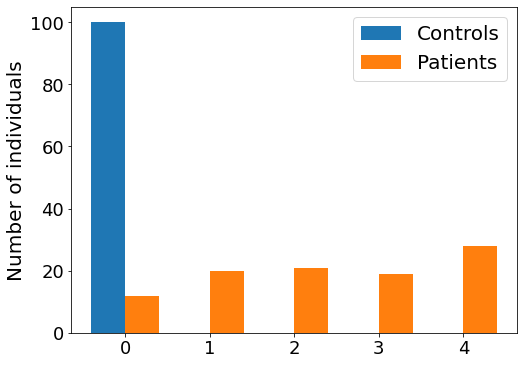

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist([ stages_long[y==0], stages_long[y==1]],bins=np.arange(-0.5,N+1.5,1))
# #* Seaborn version: requires creating a Pandas DataFrame and adding data/etc.
# ax = sns.histplot(
#     data = df_staging,
#     x    = stage_column,
#     hue  = "Status",
#     ax   = ax
#     discrete  = True,
#     multiple  = "dodge",
#     log_scale = (False, True),
#     palette   = status_palette,
# )
ax.set_ylabel('Number of individuals',fontsize=20)
ax.legend(['Controls','Patients'],fontsize=20)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

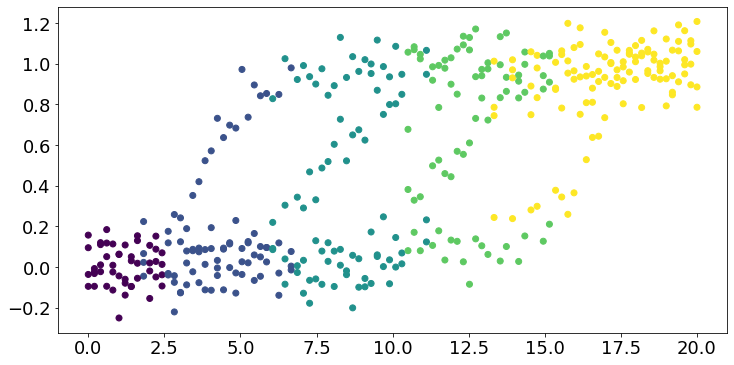

In [18]:
#* Plot the original data, coloured by stage
fig,ax = plt.subplots(figsize=(12,6))

for k in range(N):
    plt.scatter(dp,X[y==1,k],c=stages_long[y==1],cmap='viridis',label='')
plt.plot
# ax.legend(['Stage %i' % k for k in range(N)],loc='center right',bbox_to_anchor=[1.5,0.5])


## (_Work In Progress_) Bonus: Cross-validation

Generalizability/robustness of a model can be quantified by **testing** the model on independent data, i.e., data not included when training the model.

Cross-validation does this by splitting the available data into train/test sets.

### k-fold cross-validation

Splitting a dataset into `k` "folds" enables calculation of model performance statistics (e.g., mean, standard deviation) over `k` test sets, using the other `k-1` folds to train the model each time.

It is common to use `k=10`, which amounts to using 90% of your data to train and 10% to test.

This process can be repeated multiple times using different random partitions (splits) into folds.


![image_kfold_cv](K-fold_cross_validation_EN.png)

By Gufosowa - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=82298768


In [19]:
# markers_all_detrended = [e+'-detrended' for e in event_markers_adcs]
# # df_staging = pd.read_csv("adcs_ebm-prepped-staging.csv")
# # x = df_staging[markers_all_detrended].values
# # y = df_staging["DX"].values.astype(int)

# #* RCV1: Repeated, stratified 5-fold CV - round 1 (ML stage is ground truth for test folds)
# k_folds = 5
# n_repeats = 10
# from sklearn.model_selection import RepeatedStratifiedKFold
# repeated_cvfolds = RepeatedStratifiedKFold(n_splits=k_folds, n_repeats=n_repeats) #, random_state=36851234)
# if "mixtures_rcv" in ebm_results:
#     kde_mixtures_rcv = ebm_results["mixtures_rcv"]
#     mcmc_samples_rcv = ebm_results["mcmc_samples_rcv"]
#     seqs_rcv = ebm_results["sequences_rcv"]
#     staging_errors_rcv = ebm_results["staging_errors_rcv"]
# else:
#     kde_mixtures_rcv, mcmc_samples_rcv, seqs_rcv, staging_errors_rcv = ebm_ute.ebm_2_repeatedcv(
#         x=x,
#         y=y,
#         events=markers_all_detrended,
#         rcv_folds=repeated_cvfolds,
#         implement_fixed_controls=True,
#         patholog_dirn_array=event_markers_adcs_disease_direction,
#         model_stage=df_staging["Model stage"].values
#     )
#     #* Save
#     ebm_results["mixtures_rcv"] = kde_mixtures_rcv
#     ebm_results["mcmc_samples_rcv"] = mcmc_samples_rcv
#     ebm_results["sequences_rcv"] = seqs_rcv
#     ebm_results["staging_errors_rcv"] = staging_errors_rcv
#     pickle_file = open(pickle_path,'wb')
#     pickle_output = pickle.dump(ebm_results, pickle_file)
#     pickle_file.close()

In [20]:
# #* Plot EBM (PVD)
# pvd_rcv, seq_rcv = ebm_ute.extract_pvd(ml_order=seqs_rcv,samples=mcmc_samples_rcv)
# reorder_rcv = np.argsort(seq_rcv)
# pvd_rcv_ = pvd_rcv[:][reorder_rcv]

# fig, ax = plt.subplots(1,1,figsize=(9, 6),sharey=False)
# labels = ebm_scores_labels
# labels_ = [labels[i].replace('TOTAL','').replace('TOT','').replace('-detrended','') for i in seq_rcv]
# ax.imshow(pvd_rcv_[:][seq_rcv], interpolation='nearest', cmap='Oranges')
# # ax.set_title('Cross-Validation',fontsize=24)

# n_biomarkers = pvd_rcv.shape[0]
# stp = 1
# fs = 14
# tick_marks_x = np.arange(0,n_biomarkers,stp)
# x_labs = range(1, n_biomarkers+1,stp)
# ax.set_xticks(tick_marks_x)
# ax.set_xticklabels(x_labs, rotation=0,fontsize=fs)
# tick_marks_y = np.arange(n_biomarkers)
# ax.set_yticks(tick_marks_y+0)
# ax.tick_params(axis='y',color='w')
# labels_trimmed = [x[2:].replace('_', ' ') if x.startswith('p_') else x.replace('_', ' ') for x in labels_]
# ax.set_yticklabels(labels_trimmed,#,np.array(labels_trimmed, dtype='object')[seq_],
#                    rotation=0, #ha='right',
#                    rotation_mode='anchor',
#                    fontsize=18)
# # ax.set_ylabel('Instrument', fontsize=28)
# ax.set_xlabel('Sequence', fontsize=22)